# Intersection and Crosswalk

In this notebook we demonstrate how to define a T-shape intersection and a crosswalk with pedestrians using AutomotiveDrivingModels.

In [1]:
using AutomotiveDrivingModels

# Explicit importation (for the tutorial)
# All the functions related to visualization
using AutoViz: RenderModel, render, render!, SceneOverlay, 
               FitToContentCamera, add_instruction!, Colorant, 
               RGBA, @colorant_str, render_dashed_line

INFO: Recompiling stale cache file /home/tim/.julia/lib/v0.6/AutomotiveDrivingModels.ji for module AutomotiveDrivingModels.
INFO: Recompiling stale cache file /home/tim/.julia/lib/v0.6/AutoViz.ji for module AutoViz.


## Generate a T shape intersection

In order to generate the road network, one first initializes a ```Roadway``` object. 

In [2]:
roadway = Roadway();

In [3]:
# Define coordinates of the entry and exit points to the intersection
r = 5.0 # turn radius
A = VecSE2(0,DEFAULT_LANE_WIDTH,-π)
B = VecSE2(0,0,0)
C = VecSE2(r,-r,-π/2)
D = VecSE2(r+DEFAULT_LANE_WIDTH,-r,π/2)
E = VecSE2(2r+DEFAULT_LANE_WIDTH,0,0)
F = VecSE2(2r+DEFAULT_LANE_WIDTH,DEFAULT_LANE_WIDTH,-π)

VecSE2({13.000, 3.000}, -3.142)

The next step consists in appending all the lanes to the road network. We can define a helper function to add a new lane to the roadway.

In [4]:
function append_to_curve!(target::Curve, newstuff::Curve)
    s_end = target[end].s
    for c in newstuff
        push!(target, CurvePt(c.pos, c.s+s_end, c.k, c.kd))
    end
    return target
end

append_to_curve! (generic function with 1 method)

Example of a lane that consists in 3 road segments, a straight curve (from the left to the center), a turning part (right turn) and a final straight curve. You can visualize the lane that has been added to the roadway

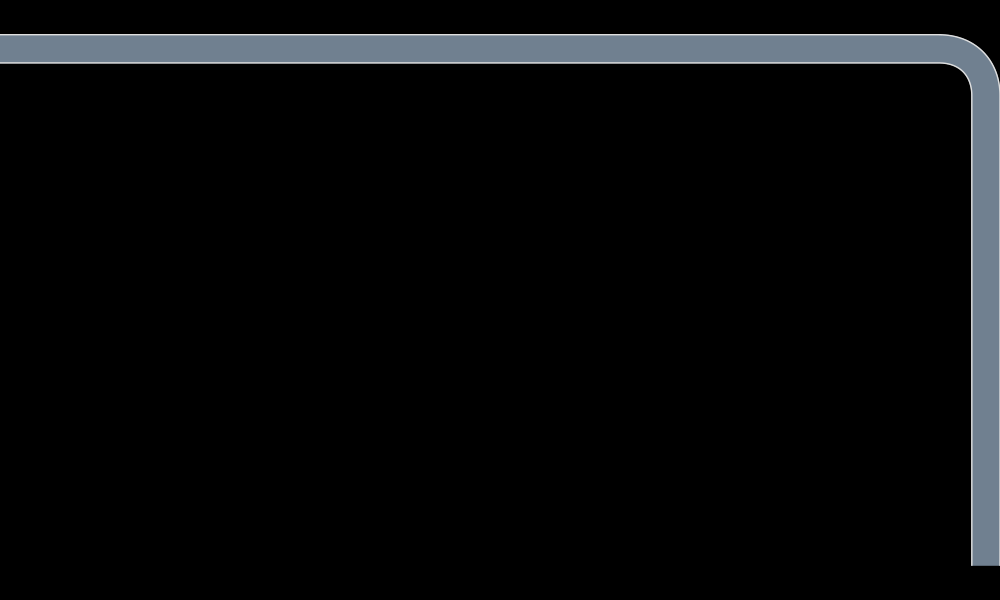

In [5]:
# Append right turn coming from the left
curve = gen_straight_curve(convert(VecE2, B+VecE2(-100,0)), convert(VecE2, B), 2)
append_to_curve!(curve, gen_bezier_curve(B, C, 0.6r, 0.6r, 51)[2:end])
append_to_curve!(curve, gen_straight_curve(convert(VecE2, C), convert(VecE2, C+VecE2(0,-50.0)), 2))
lane = Lane(LaneTag(length(roadway.segments)+1,1), curve)
push!(roadway.segments, RoadSegment(lane.tag.segment, [Lane(lane)]))

#visualize first lane
cam = FitToContentCamera(0.0)
render(roadway, cam=cam)

Let's repeat the process and complete the T-shape intersection

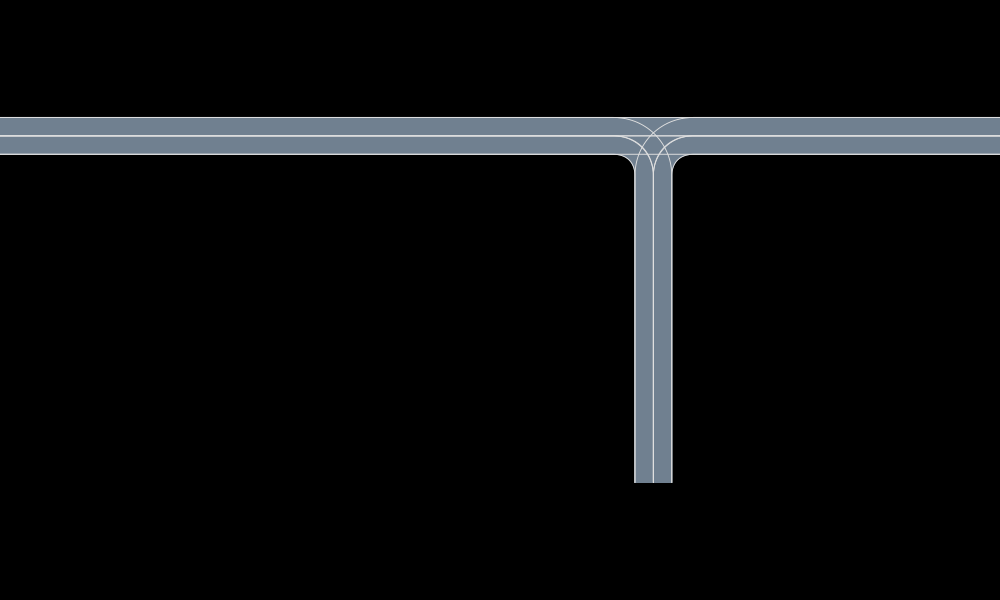

In [6]:
# Append straight left
curve = gen_straight_curve(convert(VecE2, B+VecE2(-100,0)), convert(VecE2, B), 2)
append_to_curve!(curve, gen_straight_curve(convert(VecE2, B), convert(VecE2, E), 2)[2:end])
append_to_curve!(curve, gen_straight_curve(convert(VecE2, E), convert(VecE2, E+VecE2(50,0)), 2))
lane = Lane(LaneTag(length(roadway.segments)+1,1), curve)
push!(roadway.segments, RoadSegment(lane.tag.segment, [Lane(lane)]))

# Append straight right
curve = gen_straight_curve(convert(VecE2, F+VecE2(50,0)), convert(VecE2, F), 2)
append_to_curve!(curve, gen_straight_curve(convert(VecE2, F), convert(VecE2, A), 2)[2:end])
append_to_curve!(curve, gen_straight_curve(convert(VecE2, A), convert(VecE2, A+VecE2(-100,0)), 2))
lane = Lane(LaneTag(length(roadway.segments)+1,1), curve)
push!(roadway.segments, RoadSegment(lane.tag.segment, [Lane(lane)]))

# Append left turn coming from the right
curve = gen_straight_curve(convert(VecE2, F+VecE2(50,0)), convert(VecE2, F), 2)
append_to_curve!(curve, gen_bezier_curve(F, C, 0.9r, 0.9r, 51)[2:end])
append_to_curve!(curve, gen_straight_curve(convert(VecE2, C), convert(VecE2, C+VecE2(0,-50)), 2))
lane = Lane(LaneTag(length(roadway.segments)+1,1), curve)
push!(roadway.segments, RoadSegment(lane.tag.segment, [Lane(lane)]))

# Append right turn coming from below
curve = gen_straight_curve(convert(VecE2, D+VecE2(0,-50)), convert(VecE2, D), 2)
append_to_curve!(curve, gen_bezier_curve(D, E, 0.6r, 0.6r, 51)[2:end])
append_to_curve!(curve, gen_straight_curve(convert(VecE2, E), convert(VecE2, E+VecE2(50,0)), 2))
lane = Lane(LaneTag(length(roadway.segments)+1,1), curve)
push!(roadway.segments, RoadSegment(lane.tag.segment, [Lane(lane)]))

# Append left turn coming from below
curve = gen_straight_curve(convert(VecE2, D+VecE2(0,-50)), convert(VecE2, D), 2)
append_to_curve!(curve, gen_bezier_curve(D, A, 0.9r, 0.9r, 51)[2:end])
append_to_curve!(curve, gen_straight_curve(convert(VecE2, A), convert(VecE2, A+VecE2(-100,0)), 2))
lane = Lane(LaneTag(length(roadway.segments)+1,1), curve)
push!(roadway.segments, RoadSegment(lane.tag.segment, [Lane(lane)]))

cam = FitToContentCamera(0.0)
render(roadway, cam=cam)

We can identify each lane thanks to the following user-defined functions. We define a ```LaneOverlay``` object that indicate the lane to highlight. One could implement any custom type to display other information on the lane. We then add a new method to the  ```render!``` function that execute the specific action (coloring in blue). Look at Autoviz.jl for more detail on the ```render!``` function.

Use the slider to highlight each lane. The number corresponds to a road segment.

**Note :** In order to render the intersection, one must first initialize a ```Scene``` object.

Interact.Options{:SelectionSlider,Any}(1: "input" = 3 Any , "i", 3, "3", 3, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6), Dict{Any,Any}(Pair{Any,Any}(4, "4"),Pair{Any,Any}(2, "2"),Pair{Any,Any}(3, "3"),Pair{Any,Any}(5, "5"),Pair{Any,Any}(6, "6"),Pair{Any,Any}(1, "1"))), Any[], Any[], true, "horizontal")

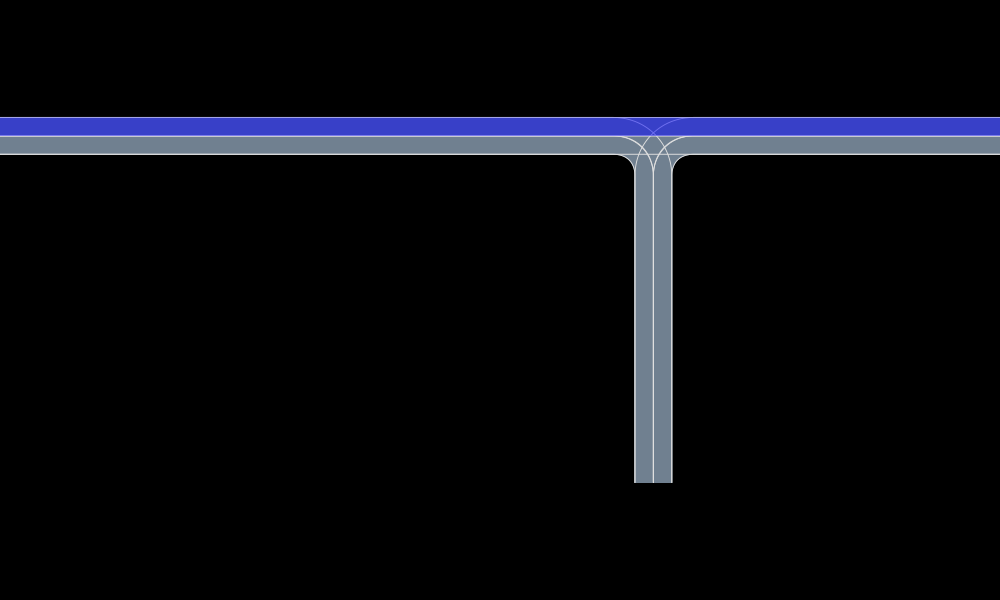

In [7]:
using Interact

scene = Scene()

type LaneOverlay <: SceneOverlay
    lane::Lane
    color::Colorant
end
function AutoViz.render!(rendermodel::RenderModel, overlay::LaneOverlay, scene::Scene, roadway::Roadway)
    render!(rendermodel, overlay.lane, roadway, color_asphalt=overlay.color)
    return rendermodel
end

# @manipulate for i in 1 : length(roadway.segments)
#     render(scene, roadway, [LaneOverlay(roadway[LaneTag(i,1)], RGBA(0.0,0.0,1.0,0.5))], cam=cam)
# end

### Navigate in the new road network

Let's populate the intersection

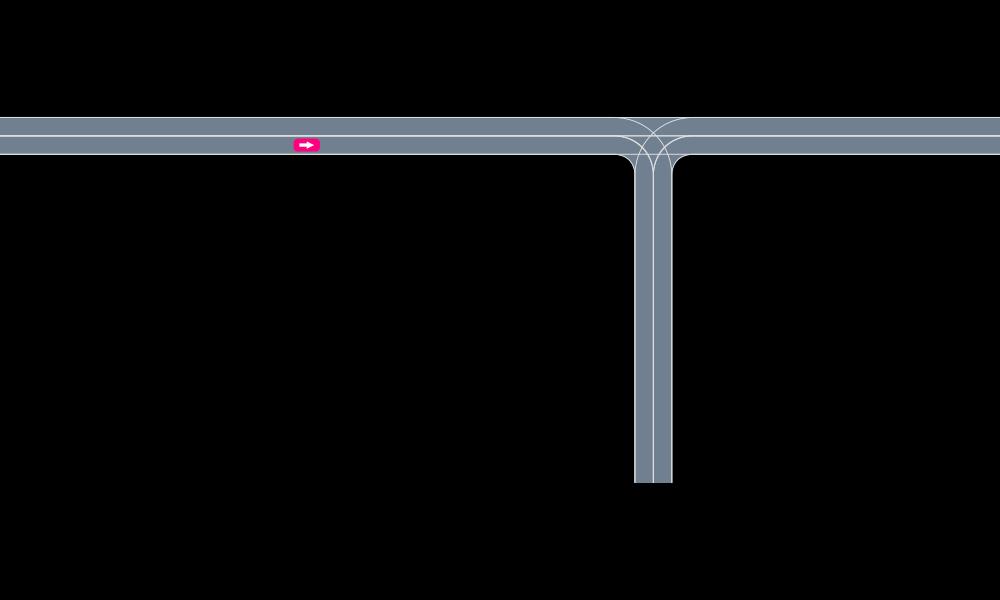

In [8]:
scene = Scene()
vs0 = RoadwayState(B + polar(50.0,-π), roadway, 8.0) # initial state of the vehicle
push!(scene, Vehicle(vs0, BoundingBoxDef(), 1)) # add vehicle with the default type

render(scene, roadway, cam=cam)

We will use lateral and longitudinal acceleration to control a car in the intersection. The first step is to define a corresponding action type that will contain the acceleration inputs.

In [9]:
immutable LaneSpecificAccelLatLon
    a_lat::Float64
    a_lon::Float64
end

Next, add a method to the propagate function to update the state using our new action type. 


**Note:** There is an existing propagate method to update the state using lateral and longitudinal acceleration. (it is used in line 3)

In [13]:
function AutomotiveDrivingModels.propagate(veh::Vehicle, action::LaneSpecificAccelLatLon, roadway::Roadway, Δt::Float64)
    lane_tag_orig = veh.state.tag
    state = propagate(veh, LatLonAccel(action.a_lat, action.a_lon), roadway, Δt)
    roadproj = proj(state.posG, roadway[lane_tag_orig], roadway, move_along_curves=false)
    retval = RoadwayState(roadproj, roadway, state.v)
    return retval
end

**Driver Model:**

We define a driver model, which can be seen as a distribution over actions. Here we will define the simplest model, which is to repeat the same action.

In [14]:
type CrosswalkDriver <: DriverModel{LaneSpecificAccelLatLon}
    a::LaneSpecificAccelLatLon
end
AutomotiveDrivingModels.get_name(model::CrosswalkDriver) = "CrosswalkDriver"
AutomotiveDrivingModels.observe!(model::CrosswalkDriver, ::Scene, ::Roadway, ::Int) = model
Base.rand(model::CrosswalkDriver) = model.a

**Simulate: **

First associate a model to each driver in the scene using a dictionnary. Here we only have one driver identified by its ID: 1. Then everything is ready to run the ```simulate!``` function.

Interact.Options{:SelectionSlider,Any}(5: "input-2" = 51 Any , "frame_index", 51, "51", 51, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…), Dict{Any,Any}(Pair{Any,Any}(68, "68"),Pair{Any,Any}(2, "2"),Pair{Any,Any}(89, "89"),Pair{Any,Any}(11, "11"),Pair{Any,Any}(39, "39"),Pair{Any,Any}(46, "46"),Pair{Any,Any}(85, "85"),Pair{Any,Any}(25, "25"),Pair{Any,Any}(55, "55"),Pair{Any,Any}(42, "42")…)), Any[], Any[], true, "horizontal")

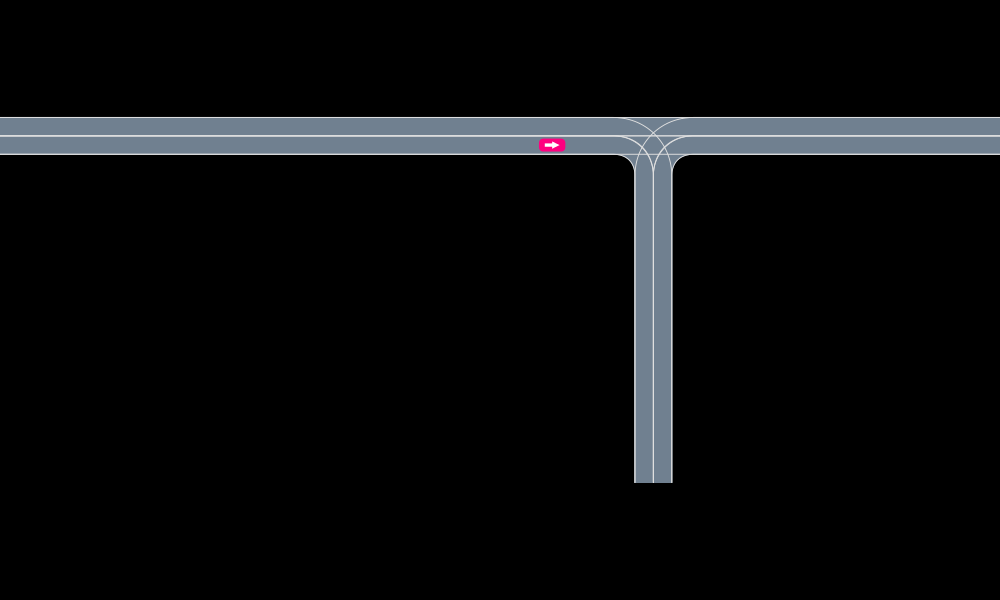

In [15]:
timestep = 0.1

models = Dict{Int, DriverModel}()
# constant speed model
models[1] = CrosswalkDriver(LaneSpecificAccelLatLon(0.0,0.0))

nticks = 100
rec = QueueRecord(Vehicle, nticks+1, timestep)
simulate!(rec, scene, roadway, models, nticks)

# interactive visualization
# @manipulate for frame_index in 1 : nframes(rec)
#     render(rec[frame_index-nframes(rec)], roadway, cam=cam)
# end

## Crosswalk Example

In this second example we demonstrate how to define a crosswalk area as well as a pedestrian agent type.

We define a new concrete type that will contain the roadway (where cars drive) and the crosswalk definition which is just a regular lane.

In [16]:
type CrosswalkEnv
    roadway::Roadway
    crosswalk::Lane
end

The crosswalk lane consists of a straight road segment perpendicular to the road. We will define the roadway just as a straight road.

In [17]:
# Define crosswalk
crosswalk = Lane(LaneTag(1,1), gen_straight_curve(VecE2(25.0, -10.0), VecE2(25.0, 10.0), 2), width=6.0)

# Generate straight roadway of length 50 with 2 lanes
roadway = gen_straight_roadway(2, 50.) 

# initialize crosswalk environment
env = CrosswalkEnv(roadway, crosswalk);

We will define a new method to render this new environment. The roadway part is just rendered regularly, we add specific instuction for the crossswalk part that will display the white stripes.

In [18]:
function AutoViz.render!(rendermodel::RenderModel, env::CrosswalkEnv)
    render!(rendermodel, env.roadway)
    
    curve = env.crosswalk.curve
    n = length(curve)
    pts = Array{Float64}(2, n)
    for (i,pt) in enumerate(curve)
        pts[1,i] = pt.pos.x
        pts[2,i] = pt.pos.y
    end

    add_instruction!(rendermodel, render_dashed_line, (pts, colorant"white", env.crosswalk.width, 1.0, 1.0, 0.0, Cairo.CAIRO_LINE_CAP_BUTT))
    return rendermodel
end

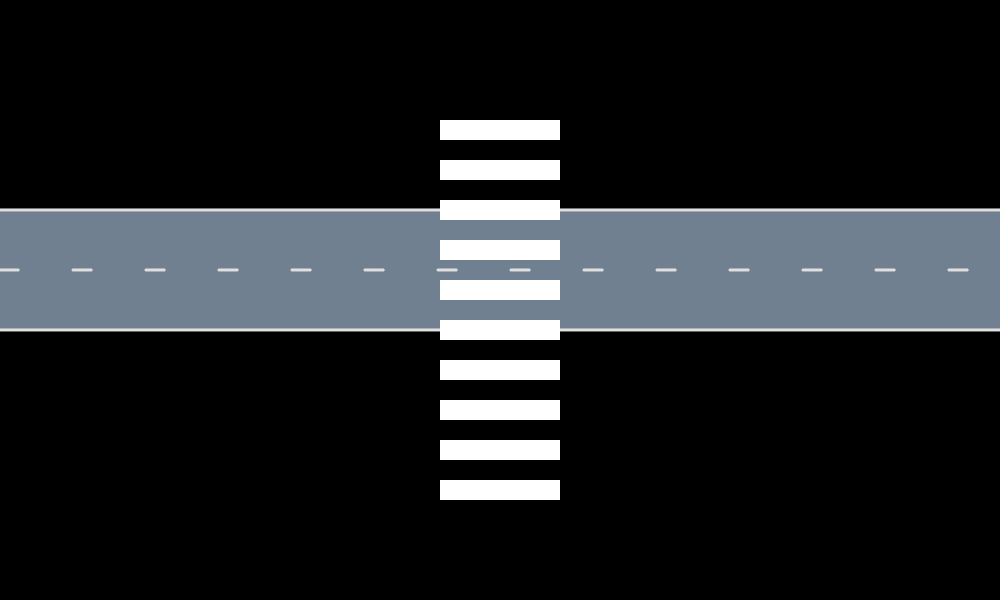

In [19]:
cam = FitToContentCamera(0.0)
render(env, cam = cam)

### Navigate the crosswalk example

Cars will be navigating in the roadway just as before. For the pedestrian we can define a new vehicle definition where we specify the size of the bounding box represented by the pedestrian.

In [22]:
# field of the BoundingBoxDef type
fieldnames(BoundingBoxDef)

3-element Array{Symbol,1}:
 :class
 :len  
 :wid  

In [23]:
# Agent.Class is from AutomotiveDrivingModels
const PEDESTRIAN_DEF = BoundingBoxDef(AgentClass.PEDESTRIAN, 1.0, 1.0)

BoundingBoxDef(PEDESTRIAN, 1.000, 1.000)

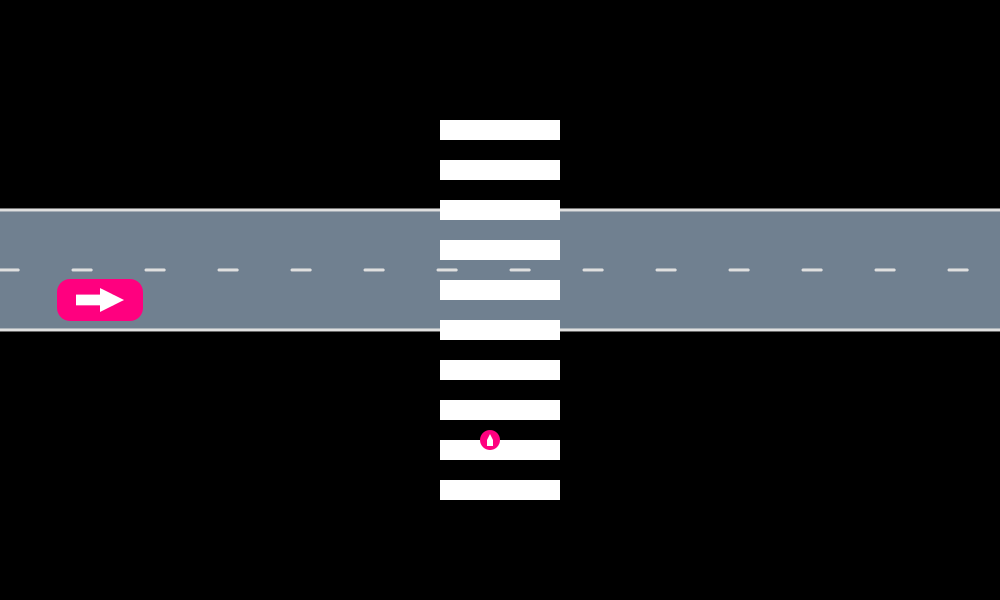

In [34]:
# Car definition
car_initial_state = RoadwayState(VecSE2(5.0, 0.0, 0.0), roadway, 8.0)
car = Vehicle(car_initial_state, BoundingBoxDef(), 1)

# Pedestrian definition using our new Vehicle definition
ped_initial_state = RoadwayState(VecSE2(+24.5,-7.0, π/2), roadway, 0.5)
ped = Vehicle(ped_initial_state, PEDESTRIAN_DEF, 2)

scene = Scene()
push!(scene, car)
push!(scene, ped)

# visualize the initial state
render(scene, env, cam=cam)

### Simulate!

As before, associate a driver model to each vehicle in the scene. We will use the model defined in the intersection example for both agents.

Interact.Options{:SelectionSlider,Any}(9: "input-3" = 51 Any , "frame_index", 51, "51", 51, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…), Dict{Any,Any}(Pair{Any,Any}(68, "68"),Pair{Any,Any}(2, "2"),Pair{Any,Any}(89, "89"),Pair{Any,Any}(11, "11"),Pair{Any,Any}(39, "39"),Pair{Any,Any}(46, "46"),Pair{Any,Any}(85, "85"),Pair{Any,Any}(25, "25"),Pair{Any,Any}(55, "55"),Pair{Any,Any}(42, "42")…)), Any[], Any[], true, "horizontal")

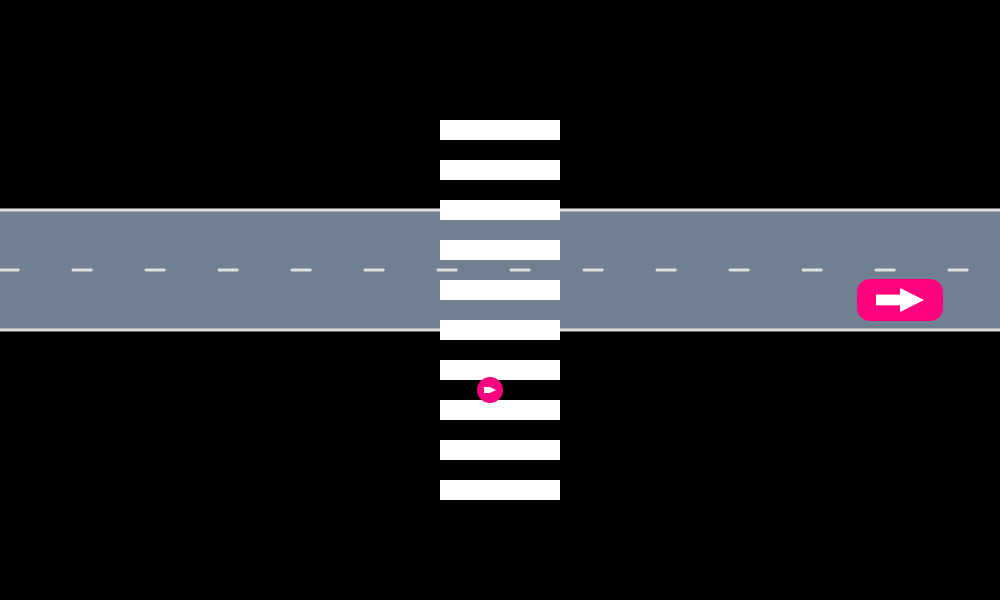

In [36]:
timestep = 0.1

models = Dict{Int, DriverModel}()
# Constant speed model
models[1] = CrosswalkDriver(LaneSpecificAccelLatLon(0.0,0.0)) 
models[2] = CrosswalkDriver(LaneSpecificAccelLatLon(0.0,0.0))

nticks = 100
rec = QueueRecord(Vehicle, nticks+1, timestep)
# execute the simulation
simulate!(rec, scene, roadway, models, nticks)

#interactive visualization
# using Interact
# @manipulate for frame_index in 1 : nframes(rec)
#     render(rec[frame_index-nframes(rec)], env, cam=cam)
# end